In [1]:
import pandas as pd

from utils import *

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

import catboost as cb

# Задание 3: использовать permutation importance, выполнить задание 1 и 2.

# task 1

In [2]:
train = load_data('../data/assignment_2_train_I.csv')
train[:2]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 457 entries, TransactionID to log_TransactionAmt
dtypes: float64(443), int64(9), object(5)
memory usage: 627.6+ MB


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,addr2_D15_std,card1_card2_D15_mean,card1_card2_D15_std,card1_card2_card3_card5_D15_mean,card1_card2_card3_card5_D15_std,card1_card2_card3_card5_addr1_addr2_D15_mean,card1_card2_card3_card5_addr1_addr2_D15_std,int_TransactionAmt,frac_TransactionAmt,log_TransactionAmt
0,2987000,0,2017-12-02 00:00:00,68.5,0,13926,NaN,150.0,3.0,142.0,...,186.33749,0.500000,0.577350,0.500000,0.577350,0.00,NaN,68,0.5,4.226834
1,2987001,0,2017-12-02 00:00:01,29.0,0,2755,404.0,150.0,1.0,102.0,...,186.33749,114.811765,177.751006,114.811765,177.751006,59.75,123.056897,29,0.0,3.367296


In [3]:
trash_cols = [col for col, val in (train.dtypes == 'object').items() if val]

train.drop(trash_cols, axis=1, inplace=True)
train.shape

(180000, 452)

In [4]:
params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "GPU",
    
    "depth": 5,
    "learning_rate": 0.1,
    
    "verbose": 100
}

In [5]:
%%time

Xtrain, Xvalid, ytrain, yvalid = train_test_split(
    train.drop('isFraud', axis=1), train['isFraud'],
    train_size=0.8, random_state=42, shuffle=True
)

pi_params = params.copy()
pi_params['iterations'] = 100

model = cb.CatBoostClassifier(**pi_params)
model.fit(Xtrain, ytrain)

importance = permutation_importance(model, Xvalid, yvalid, scoring='roc_auc', random_state=42)

0:	learn: 0.6759022	total: 19.6ms	remaining: 1.94s
99:	learn: 0.8987344	total: 2.02s	remaining: 0us
Wall time: 2min 26s


count of importanse features: 159
Wall time: 488 ms


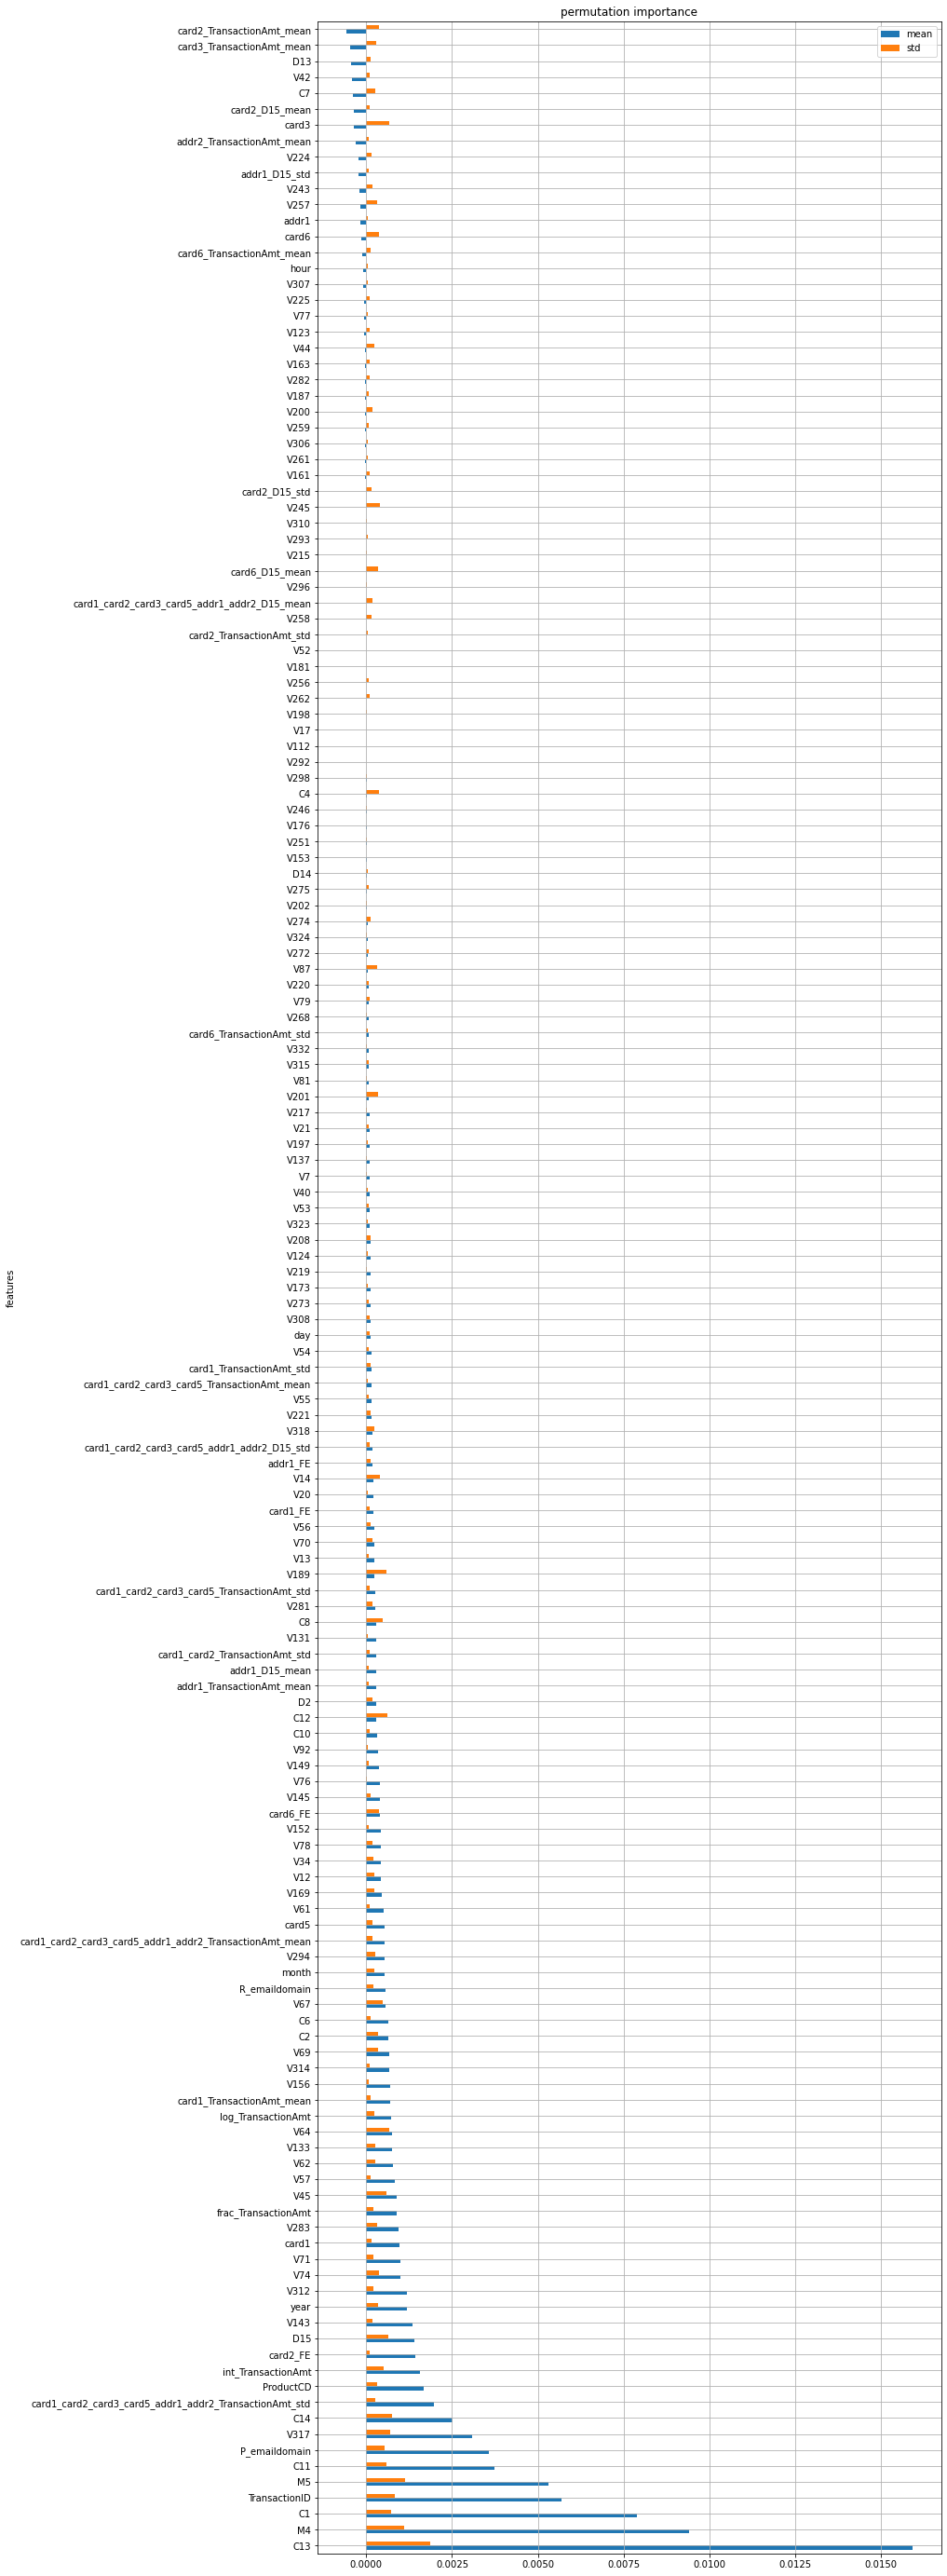

In [6]:
%%time
def feature_permutation_importance(imporance, columns, figsize=(12, 50)):
    df = pd.DataFrame({
        'features': columns,
        'mean': importance.importances_mean,
        'std': importance.importances_std
    })
    df = df[(df['mean'] != 0) & (df['std'] != 0)]
    df.sort_values(by='mean', ascending=False, inplace=True)
    df.set_index('features', inplace=True)
    
    print(f'count of importanse features: {len(df)}')
    
    df.plot(kind='barh', figsize=figsize, grid=True, title='permutation importance')
    return df

perm_FI = feature_permutation_importance(importance, Xvalid.columns, figsize=(12, 50))

(144000, 121)
(36000, 121)
(144000,)
(36000,)

0:	learn: 0.6476972	test: 0.6416407	best: 0.6416407 (0)	total: 22.1ms	remaining: 22.1s
100:	learn: 0.9023552	test: 0.8961000	best: 0.8961000 (100)	total: 1.88s	remaining: 16.7s
200:	learn: 0.9178205	test: 0.9086431	best: 0.9086431 (200)	total: 3.97s	remaining: 15.8s
300:	learn: 0.9279246	test: 0.9165416	best: 0.9165416 (300)	total: 6.14s	remaining: 14.3s
400:	learn: 0.9349272	test: 0.9216585	best: 0.9216585 (400)	total: 8.28s	remaining: 12.4s
500:	learn: 0.9400350	test: 0.9250789	best: 0.9250896 (497)	total: 10.3s	remaining: 10.3s
600:	learn: 0.9452153	test: 0.9289297	best: 0.9289390 (599)	total: 12.2s	remaining: 8.09s
700:	learn: 0.9500120	test: 0.9323138	best: 0.9323197 (696)	total: 14s	remaining: 5.99s
800:	learn: 0.9554226	test: 0.9354095	best: 0.9354095 (800)	total: 16s	remaining: 3.96s
900:	learn: 0.9585946	test: 0.9370383	best: 0.9370383 (900)	total: 18s	remaining: 1.98s
999:	learn: 0.9619638	test: 0.9389275	best: 0.9390231 (994)	to

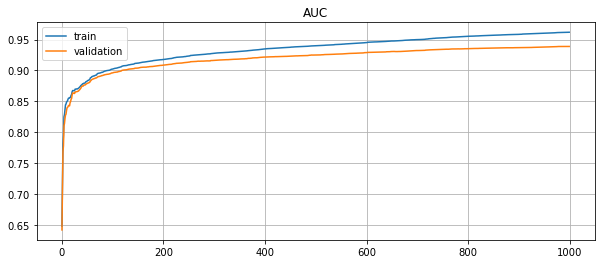

In [7]:
cb_model, eval_valid = trainingCatBoost(
    train[list(perm_FI[perm_FI['mean'] > 0].index) + ['isFraud']], 
    target='isFraud',
    params=params,
)

In [8]:
scores = ScoresAUC('roc_auc')
scores.load_csv()
scores.add_score(eval_valid, 'perm_imp')

,roc_auc
base_line,0.9384
above_zero,0.9383
perm_imp,0.9389
perm_imp_zero,0.9363


# task 2

In [9]:
train = load_data('../data/assignment_2_train_II.csv')
train[:2]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 365 entries, C13 to isFraud
dtypes: float64(356), int64(9)
memory usage: 501.3 MB


,C13,M4,TransactionID,P_emaildomain,V317,card1,R_emaildomain,M5,C14,card1_card2_card3_card5_addr1_addr2_TransactionAmt_std,...,V119,V93,addr2_D15_std,V249,V252,V179,V114,V110,V117,isFraud
0,1.0,1.0,2987000,NaN,117.0,13926,NaN,0.0,1.0,NaN,...,1.0,0.0,186.33749,NaN,NaN,NaN,1.0,1.0,1.0,0
1,1.0,0.0,2987001,0.0,0.0,2755,NaN,1.0,1.0,270.054718,...,1.0,0.0,186.33749,NaN,NaN,NaN,1.0,1.0,1.0,0


In [10]:
%%time

Xtrain, Xvalid, ytrain, yvalid = train_test_split(
    train.drop('isFraud', axis=1), train['isFraud'],
    train_size=0.8, random_state=42, shuffle=True
)

model = cb.CatBoostClassifier(**pi_params)
model.fit(Xtrain, ytrain)

importance = permutation_importance(model, Xvalid, yvalid, scoring='roc_auc', random_state=42)

0:	learn: 0.6866357	total: 17.9ms	remaining: 1.77s
99:	learn: 0.9010520	total: 1.89s	remaining: 0us
Wall time: 1min 43s


count of importanse features: 156


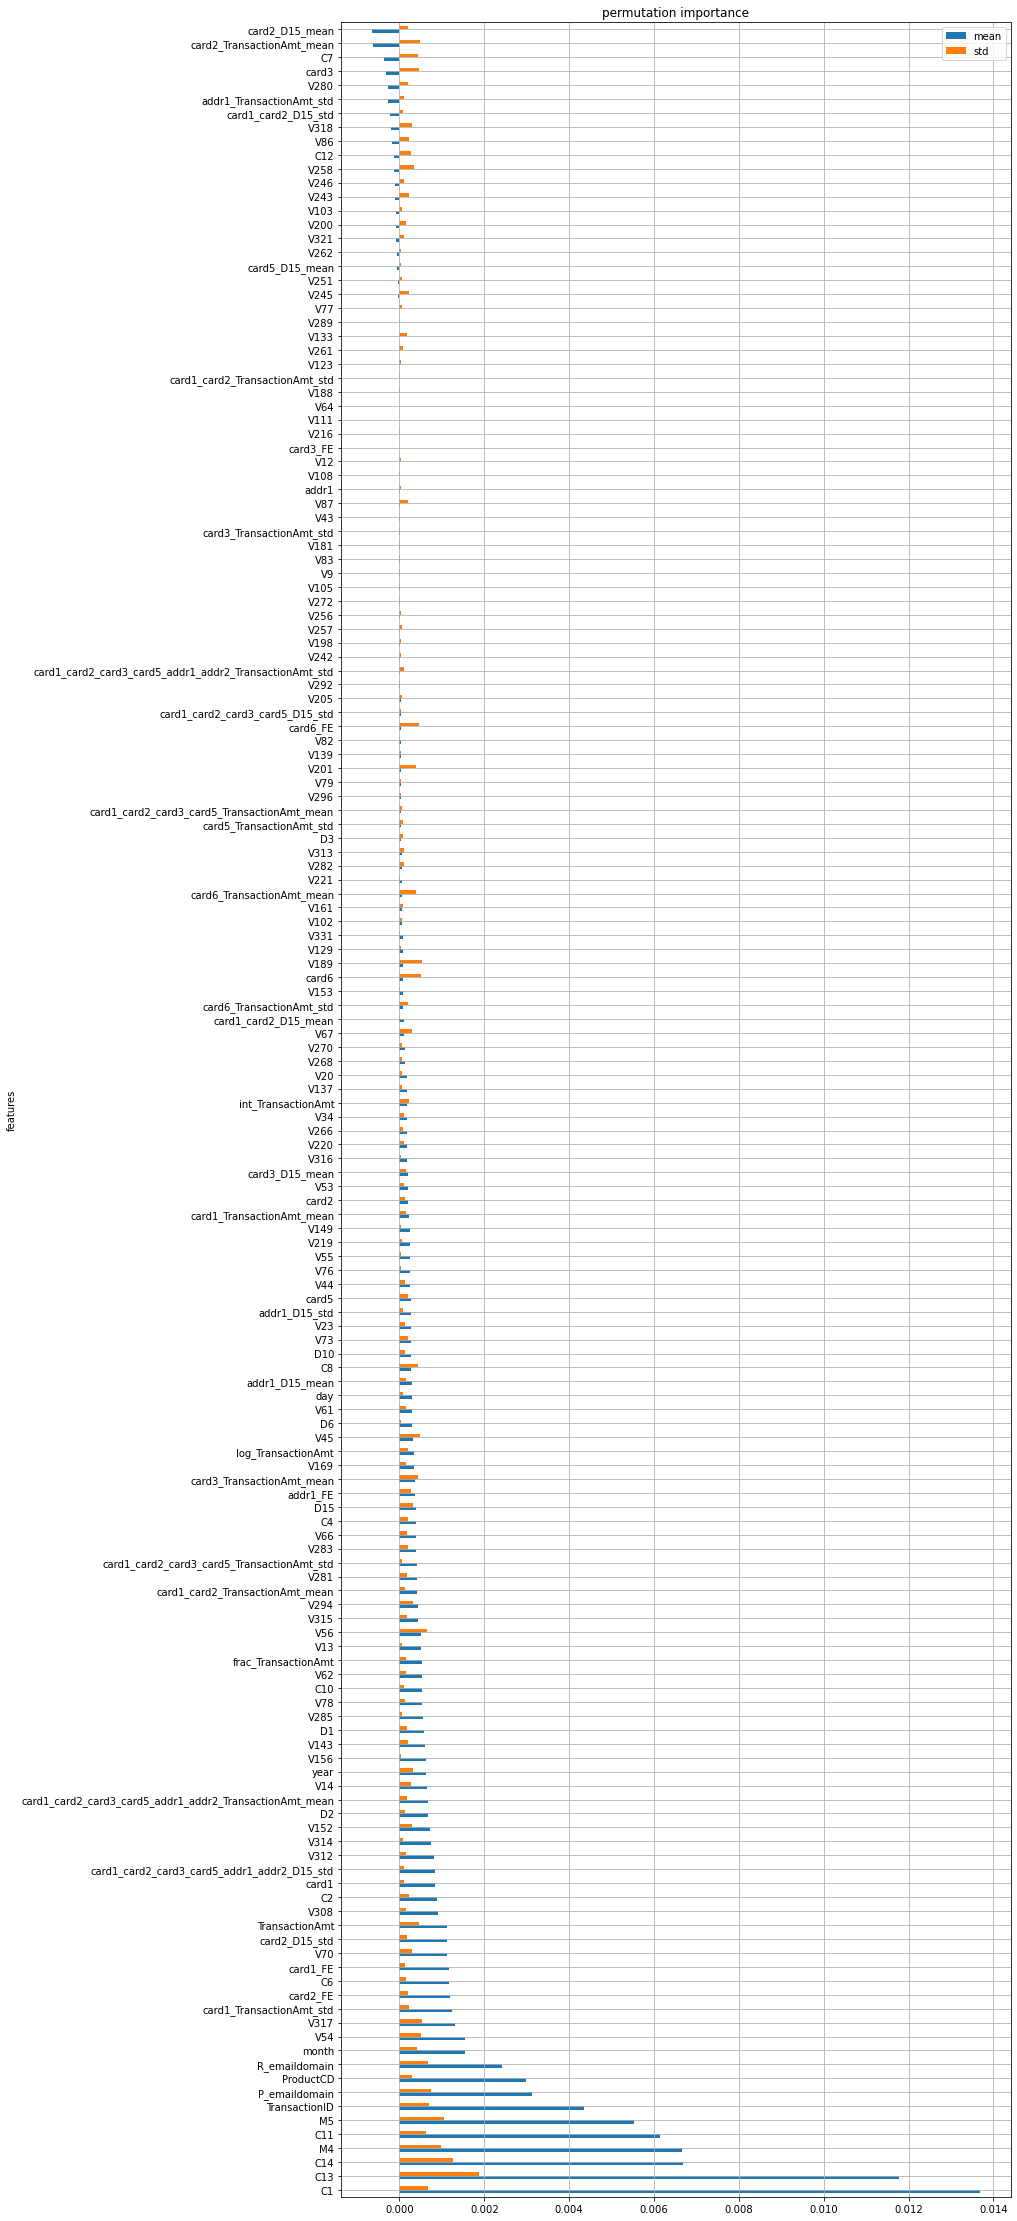

In [11]:
perm_zero_FI = feature_permutation_importance(importance, Xvalid.columns, figsize=(12, 40))

(144000, 128)
(36000, 128)
(144000,)
(36000,)

0:	learn: 0.7001916	test: 0.6894951	best: 0.6894951 (0)	total: 17.8ms	remaining: 17.8s
100:	learn: 0.9009878	test: 0.8933132	best: 0.8933398 (99)	total: 2s	remaining: 17.8s
200:	learn: 0.9188201	test: 0.9085675	best: 0.9085675 (200)	total: 3.83s	remaining: 15.2s
300:	learn: 0.9296082	test: 0.9162915	best: 0.9162915 (300)	total: 5.68s	remaining: 13.2s
400:	learn: 0.9362317	test: 0.9208517	best: 0.9210279 (399)	total: 7.64s	remaining: 11.4s
500:	learn: 0.9418401	test: 0.9238996	best: 0.9238996 (500)	total: 9.64s	remaining: 9.61s
600:	learn: 0.9467126	test: 0.9273364	best: 0.9273430 (599)	total: 11.5s	remaining: 7.65s
700:	learn: 0.9512182	test: 0.9303673	best: 0.9303673 (700)	total: 13.4s	remaining: 5.71s
800:	learn: 0.9547489	test: 0.9324597	best: 0.9325127 (794)	total: 15.3s	remaining: 3.79s
900:	learn: 0.9584775	test: 0.9343230	best: 0.9343230 (900)	total: 17.1s	remaining: 1.88s
999:	learn: 0.9625177	test: 0.9362720	best: 0.9362998 (998)	

,roc_auc
base_line,0.9384
above_zero,0.9383
perm_imp,0.9389
perm_imp_zero,0.9363


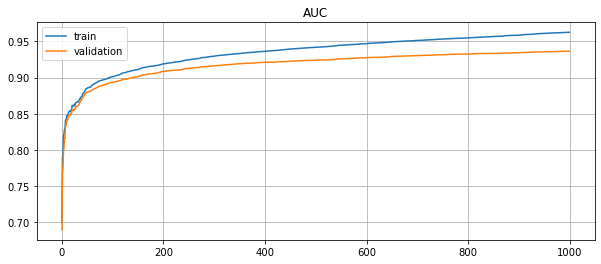

In [12]:
cb_model, eval_valid = trainingCatBoost(
    train[list(perm_zero_FI[perm_zero_FI['mean'] > 0].index) + ['isFraud']], 
    target='isFraud',
    params=params,
)

scores.add_score(eval_valid, 'perm_imp_zero')

In [13]:
scores.save_csv()

## Вывод:

- фичи __С13__, __TransactionID__, __M5__, __P_emaildomain__, __V317__, __C14__ действительно являются важными
- при комбинации __feature_importance__ и __permutation_importance__ - точность упала еще ниже